# **Analyse sur la pandémie de Covid-19 en janvier-mai 2020**

***
**Table des matières :**
* [1. La répartition du début de confinement (total et partiel)](#1)
* [2. La propagation du Covid-19 en fonction du nombre des pays cumulés](#2)
* [3. La répartition des délais entre le premier cas et le confinement (total et partiel)](#3)
* [4. La répartition des écarts entre le premier cas et le premier mort](#4)
***

**Étudiant :**
- Zhifeng LIANG

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install geopandas
!pip install mapclassify

In [ ]:
import regex as re
import datetime
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import geopandas as gpd
from pyspark.sql import SparkSession

In [ ]:
# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkCovid') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 2


In [ ]:
# https://www.kaggle.com/ishivinal/covid19-useful-features-by-country
table_covid = sc.textFile('/content/drive/MyDrive/Cours_HETIC/Architecure_Programmation/data/Countries_usefulFeatures.csv')
# https://ramiro.org/notebook/geopandas-choropleth/
gdf = gpd.read_file('/content/drive/MyDrive/Cours_HETIC/Architecure_Programmation/data/geo/natural_earth_data/ne_10m_admin_0_countries_lakes.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

In [ ]:
header_covid = table_covid.take(1)
table_covid_no_header = table_covid.filter(lambda row: row != header_covid[0])
print("Nombre de lignes : ", table_covid_no_header.count())
rx = re.compile(r'"[^"]*"(*SKIP)(*FAIL)|,\s*')
table_covid_splited = table_covid_no_header.map(lambda line: rx.split(line))

Nombre de lignes :  184


<a id='1'></a>
## **1. La répartition du début de confinement (total et partiel)**

In [ ]:
dates_con = table_covid_splited.filter(lambda x: x[8] != '' and x[9] != '') \
                               .map(lambda x: ((datetime.datetime.strptime(x[8], '%Y-%m-%d'), x[9]), 1)) \
                               .reduceByKey(lambda x, y: x + y) \
                               .sortBy(lambda x: x[0][0])

In [ ]:
dates_con_full = dates_con.filter(lambda x: x[0][1] == 'Full').collect()
dates_con_partial = dates_con.filter(lambda x: x[0][1] == 'Partial').collect()

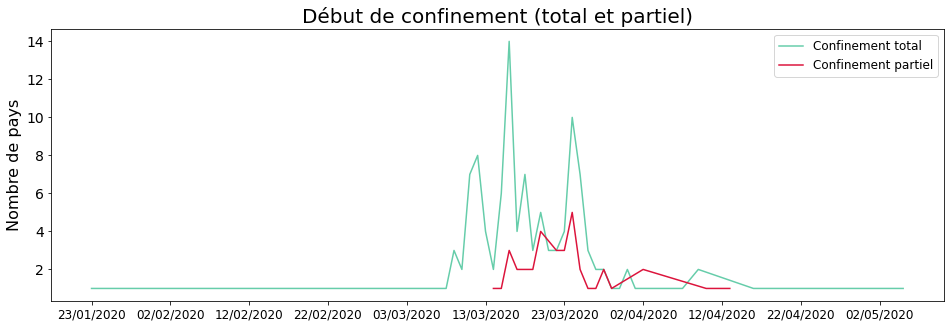

In [ ]:
plt.figure(figsize=(16,5))
plt.plot([val[0][0] for val in dates_con_full], [val[1] for val in dates_con_full], color='mediumaquamarine')
plt.plot([val[0][0] for val in dates_con_partial], [val[1] for val in dates_con_partial], color='crimson')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
# plt.gcf().autofmt_xdate() # Rotation
plt.title("Début de confinement (total et partiel)", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylabel('Nombre de pays', fontsize=16)
plt.legend(['Confinement total', 'Confinement partiel'], fontsize=12)
plt.show()

<a id='2'></a>
## **2. La propagation du Covid-19 en fonction du nombre des pays cumulés**

In [ ]:
dates_num_countries = table_covid_splited.filter(lambda x: x[3] != '') \
                                         .map(lambda x: ((datetime.datetime.strptime(x[3], '%Y-%m-%d'), 1))) \
                                         .reduceByKey(lambda x, y: x + y) \
                                         .sortBy(lambda x: x[0]) \
                                         .collect()

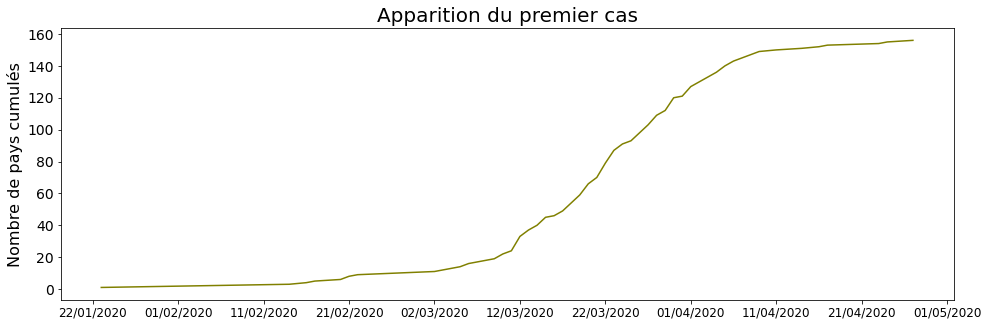

In [ ]:
plt.figure(figsize=(16,5))
plt.plot([x for x, y in dates_num_countries], np.cumsum([y for x, y in dates_num_countries]), color='olive')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
# plt.gcf().autofmt_xdate() # Rotation
plt.title("Apparition du premier cas", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylabel('Nombre de pays cumulés', fontsize=16)
plt.show()

<a id='3'></a>
## **3. La répartition des délais entre le premier cas et le confinement (total et partiel)**

In [ ]:
days_react = table_covid_splited.filter(lambda x: x[4] != '' and x[-3] != '') \
                                .map(lambda x: (x[0], x[-1], (datetime.datetime.strptime(x[-3], '%Y-%m-%d') - datetime.datetime.strptime(x[4], '%Y-%m-%d')).days)) \
                                .collect()

In [ ]:
df_react = pd.DataFrame(days_react, columns=['country', 'code', 'days_react'])

In [ ]:
df_gdf_react = gdf.merge(df_react, left_on='ADM0_A3', right_on='code', how='left')

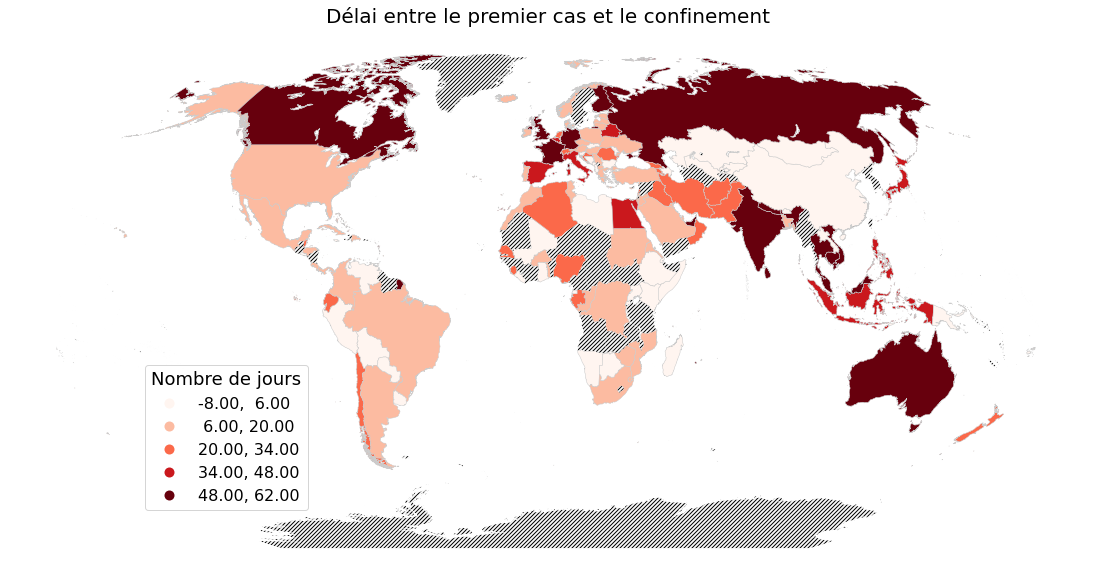

In [ ]:
# https://stackoverflow.com/questions/52503899/format-round-numerical-legend-label-in-geopandas
fig, ax = plt.subplots(figsize=(20, 10))
df_gdf_react.plot(ax=ax, column='days_react', cmap='Reds', figsize=(20, 10), scheme='equal_interval', k=5, linewidth=0.5, edgecolor='0.8', legend=True, 
                  legend_kwds={'fontsize':'16', 'loc':'lower left', 'bbox_to_anchor': (0.12, 0.1), 'title': "Nombre de jours", 'title_fontsize': 18})
df_gdf_react[df_gdf_react.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='//////')
plt.title("Délai entre le premier cas et le confinement", fontsize=20)
plt.axis('off')
plt.show()

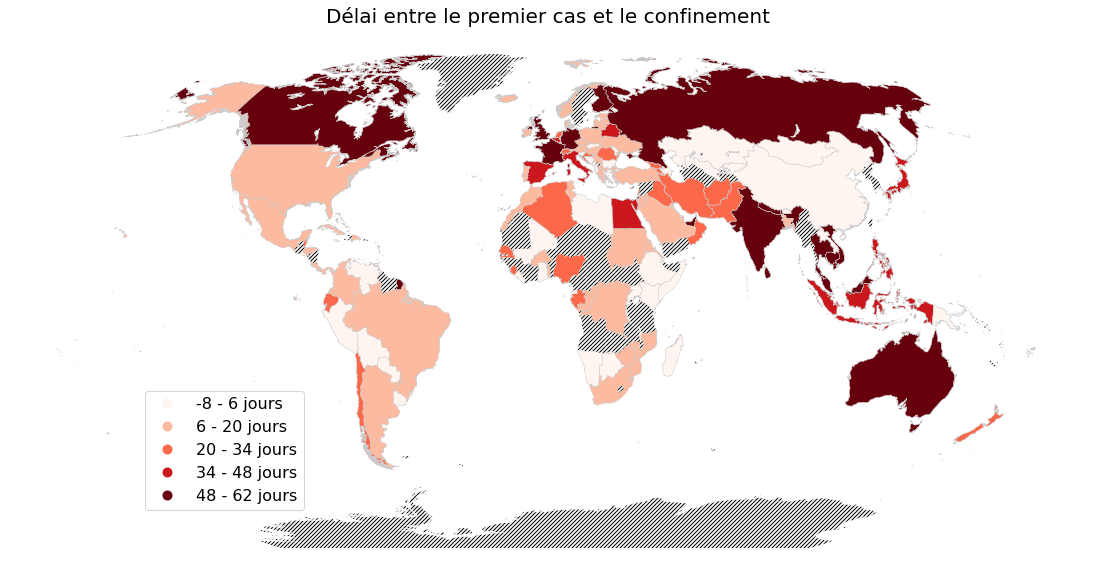

In [ ]:
# https://stackoverflow.com/questions/52503899/format-round-numerical-legend-label-in-geopandas
fig, ax = plt.subplots(figsize=(20, 10))
df_gdf_react.plot(ax=ax, column='days_react', cmap='Reds', scheme='equal_interval', k=5, linewidth=0.5, edgecolor='0.8', legend=True, 
                  legend_kwds={'fontsize':'16', 'loc':'lower left', 'bbox_to_anchor': (0.12, 0.1)})
df_gdf_react[df_gdf_react.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='//////')
plt.title("Délai entre le premier cas et le confinement", fontsize=20)
plt.axis('off')

# get all upper bounds
upper_bounds = mapclassify.EqualInterval(df_gdf_react.days_react, k=5).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = df_gdf_react.days_react.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound + ' jours')

plt.show()

<a id='4'></a>
## **4. La répartition des écarts entre le premier cas et le premier mort**

In [ ]:
days_alive = table_covid_splited.filter(lambda x: x[3] != '' and x[4] != '') \
                                .map(lambda x: (x[0], x[-1], (datetime.datetime.strptime(x[3], '%Y-%m-%d') - datetime.datetime.strptime(x[4], '%Y-%m-%d')).days)) \
                                .collect()

In [ ]:
df_alive = pd.DataFrame(days_alive, columns=['country', 'code', 'days_alive'])

In [ ]:
df_gdf_alive = gdf.merge(df_alive, left_on='ADM0_A3', right_on='code', how='left')

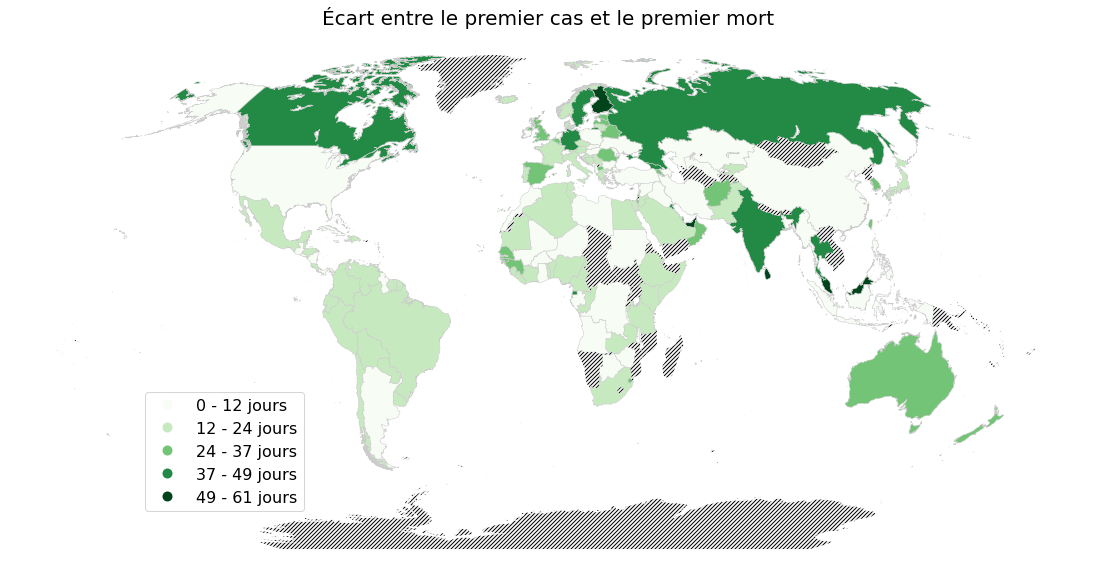

In [ ]:
# https://stackoverflow.com/questions/52503899/format-round-numerical-legend-label-in-geopandas
fig, ax = plt.subplots(figsize=(20, 10))
df_gdf_alive.plot(ax=ax, column='days_alive', cmap='Greens', scheme='equal_interval', k=5, linewidth=0.5, edgecolor='0.8', legend=True, 
                  legend_kwds={'fontsize':'16', 'loc':'lower left', 'bbox_to_anchor': (0.12, 0.1)})
df_gdf_alive[df_gdf_alive.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='//////')
plt.title("Écart entre le premier cas et le premier mort", fontsize=20)
plt.axis('off')

# get all upper bounds
upper_bounds = mapclassify.EqualInterval(df_gdf_alive.days_alive, k=5).bins

# get and format all bounds
bounds = []
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = df_gdf_alive.days_alive.min()
    else:
        lower_bound = upper_bounds[index-1]

    # format the numerical legend here
    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = ax.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound + ' jours')

plt.show()